In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline


Kích thước dữ liệu tổng hợp: (918, 12)
Kích thước Train set: (734, 11)
Kích thước Test set: (184, 11)

Median Cholesterol (từ Train set): 237.0
Số lượng giá trị 0 trong Cholesterol (Train): 0
Số lượng giá trị 0 trong Cholesterol (Test): 0


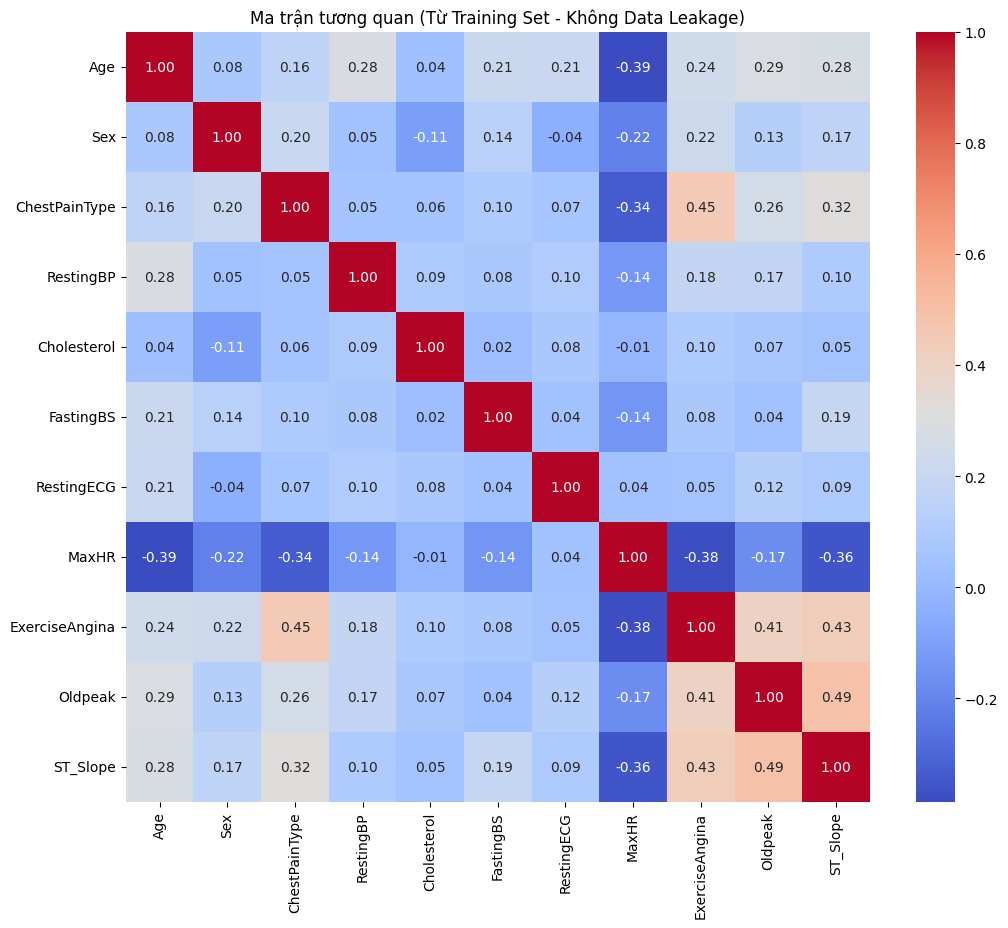

In [40]:
# --- BƯỚC 1: ĐỌC VÀ ĐỒNG BỘ DỮ LIỆU (TỪ RAW DATA) ---

data = pd.read_csv('heart.csv')  # Dữ liệu chữ

# Từ điển ánh xạ để chuyển chữ sang số
mapping_config = {
    'ChestPainType': {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3},
    'RestingECG':    {'Normal': 0, 'ST': 1, 'LVH': 2},
    'ExerciseAngina':{'Y': 1, 'N': 0},
    'ST_Slope':      {'Up': 0, 'Flat': 1, 'Down': 2},
    'Sex':           {'M': 1, 'F': 0}
}

df_final = data.copy()
for col, mapping in mapping_config.items():
    df_final[col] = df_final[col].map(mapping)

# Xử lý Cholesterol = 0 thành NaN (chưa fill vào ngay)
df_final['Cholesterol'] = df_final['Cholesterol'].replace(0, np.nan)

# Loại bỏ duplicate rows
df_final = df_final.drop_duplicates()
print(f"Kích thước dữ liệu tổng hợp: {df_final.shape}")

# ⚠️ QUAN TRỌNG: CHIA TRAIN/TEST TRƯỚC KHI PREPROCESSING ĐỂ TRÁNH DATA LEAKAGE ⚠️
# Tách feature và target
X = df_final.drop('HeartDisease', axis=1)
y = df_final['HeartDisease']

# Chia tập dữ liệu 80% Train - 20% Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Kích thước Train set: {X_train.shape}")
print(f"Kích thước Test set: {X_test.shape}")

# --- BƯỚC 2: PREPROCESSING - TỰA TRÊN TRAIN SET ONLY ---
# Tính median Cholesterol chỉ từ training set
cholesterol_median_train = X_train['Cholesterol'].median()
print(f"\nMedian Cholesterol (từ Train set): {cholesterol_median_train}")

# Fill NaN bằng median từ training set cho CẢ Train và Test
X_train['Cholesterol'] = X_train['Cholesterol'].fillna(cholesterol_median_train)
X_test['Cholesterol'] = X_test['Cholesterol'].fillna(cholesterol_median_train)

# Xử lý các missing values còn lại
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print(f"Số lượng giá trị 0 trong Cholesterol (Train): {(X_train['Cholesterol'] == 0).sum()}")
print(f"Số lượng giá trị 0 trong Cholesterol (Test): {(X_test['Cholesterol'] == 0).sum()}")

# --- BƯỚC 3: TRỰC QUAN HÓA TƯƠNG QUAN (DỰA TRÊN TRAIN SET) ---
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Ma trận tương quan (Từ Training Set - Không Data Leakage)")
plt.show()


✓ StandardScaler được fit chỉ trên Training Set (Đúng cách)

=== KẾT QUẢ MÔ HÌNH CƠ SỞ (Ngưỡng 0.5) ===
Độ chính xác (Accuracy): 85.33%
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        77
           1       0.91      0.83      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



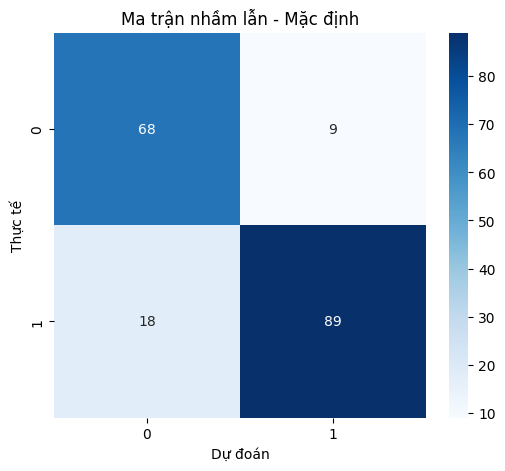

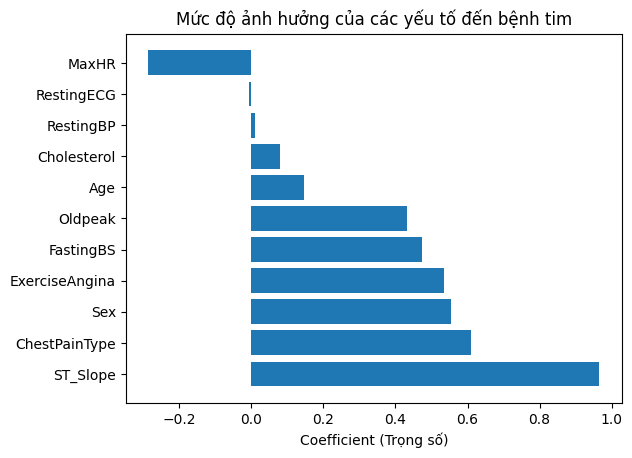

In [41]:
# --- BƯỚC 4: CHUẨN HÓA DỮ LIỆU (STANDARD SCALING) ---
# Fit scaler CHỈ trên training set, sau đó transform cả train và test

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit trên Train, sau đó transform
X_test_scaled = scaler.transform(X_test)        # CHỈ transform Test (không fit)

print("✓ StandardScaler được fit chỉ trên Training Set (Đúng cách)")

# --- BƯỚC 5: HUẤN LUYỆN LOGISTIC REGRESSION ---
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# --- BƯỚC 6: ĐÁNH GIÁ MẶC ĐỊNH (Ngưỡng 0.5) ---
y_pred = model.predict(X_test_scaled)

print("\n=== KẾT QUẢ MÔ HÌNH CƠ SỞ (Ngưỡng 0.5) ===")
print(f"Độ chính xác (Accuracy): {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(classification_report(y_test, y_pred))

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn - Mặc định')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

importance = model.coef_[0]
feature_names = X_train.columns

# Tạo DataFrame để dễ quan sát
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Vẽ biểu đồ
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Mức độ ảnh hưởng của các yếu tố đến bệnh tim')
plt.xlabel('Coefficient (Trọng số)')
plt.show()



=== KẾT QUẢ TỐI ƯU (Ngưỡng 0.2) ===
              precision    recall  f1-score   support

           0       0.88      0.65      0.75        77
           1       0.79      0.93      0.85       107

    accuracy                           0.82       184
   macro avg       0.83      0.79      0.80       184
weighted avg       0.82      0.82      0.81       184



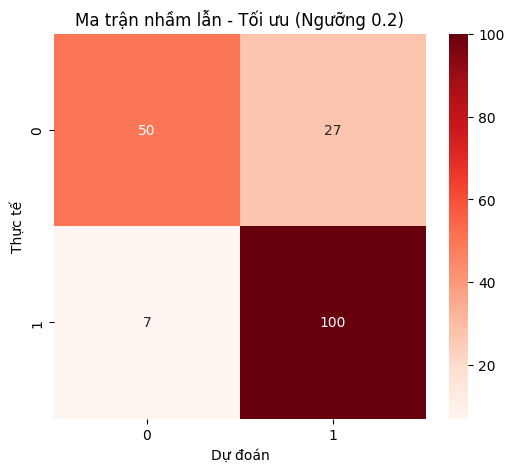

In [42]:
# --- BƯỚC 7: TỐI ƯU HÓA NGƯỠNG (THRESHOLD TUNING) ---

# Lấy xác suất dự đoán thay vì nhãn 0/1
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Đặt ngưỡng mới an toàn hơn (0.3)
new_threshold = 0.2
y_pred_new = (y_prob >= new_threshold).astype(int)

print(f"\n=== KẾT QUẢ TỐI ƯU (Ngưỡng {new_threshold}) ===")
print(classification_report(y_test, y_pred_new))

# Vẽ Confusion Matrix so sánh
plt.figure(figsize=(6, 5))
cm_new = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm_new, annot=True, fmt='d', cmap='Reds')
plt.title(f'Ma trận nhầm lẫn - Tối ưu (Ngưỡng {new_threshold})')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()


=== HUẤN LUYỆN LẠI VỚI TRỌNG SỐ {0: 1, 1: 3} ===
Báo cáo chi tiết (Class Weight Model):
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        77
           1       0.87      0.93      0.90       107

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184



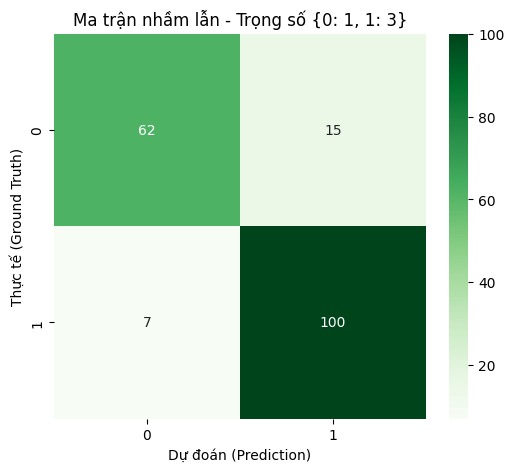

In [43]:
# --- BƯỚC 8: CÁCH 2 - SỬ DỤNG TRỌNG SỐ LỚP (CLASS WEIGHT) ---
# Mục tiêu: Ép mô hình coi trọng người bệnh (nhãn 1) hơn người khỏe (nhãn 0) ngay khi học.

# Định nghĩa trọng số: {0: 1, 1: 3}
# Ý nghĩa: Bỏ sót 1 người bệnh (False Negative) bị phạt nặng bằng đoán sai 3 người khỏe.
# Bạn có thể thử thay số 3 bằng 2, 4, 5 để xem Recall thay đổi thế nào.
custom_weights = {0: 1, 1: 3}

print(f"\n=== HUẤN LUYỆN LẠI VỚI TRỌNG SỐ {custom_weights} ===")

# 1. Khởi tạo mô hình MỚI với tham số class_weight
# Lưu ý: Phải train lại từ đầu
model_weighted = LogisticRegression(class_weight=custom_weights, random_state=42)

# 2. Huấn luyện lại
model_weighted.fit(X_train_scaled, y_train)

# 3. Dự đoán
# Lưu ý: Với cách này, ta dùng ngưỡng mặc định 0.5 là đã tốt rồi,
# vì sự thiên vị đã được tích hợp vào công thức toán học bên trong.
y_pred_weighted = model_weighted.predict(X_test_scaled)

# 4. In báo cáo
print("Báo cáo chi tiết (Class Weight Model):")
print(classification_report(y_test, y_pred_weighted))

# 5. Vẽ Confusion Matrix so sánh
plt.figure(figsize=(6, 5))
cm_weighted = confusion_matrix(y_test, y_pred_weighted)
# Dùng màu Xanh Lá (Greens) để phân biệt với 2 cách trước
sns.heatmap(cm_weighted, annot=True, fmt='d', cmap='Greens')
plt.title(f'Ma trận nhầm lẫn - Trọng số {custom_weights}')
plt.ylabel('Thực tế (Ground Truth)')
plt.xlabel('Dự đoán (Prediction)')
plt.show()


=== KẾT QUẢ KẾT HỢP: CLASS WEIGHT + THRESHOLD 0.35 ===
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        77
           1       0.77      0.94      0.85       107

    accuracy                           0.80       184
   macro avg       0.82      0.77      0.78       184
weighted avg       0.82      0.80      0.79       184



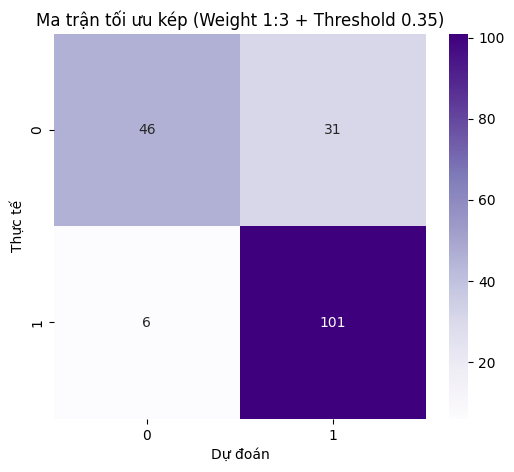

In [44]:
# --- BƯỚC 9: KẾT HỢP CẢ 2 PHƯƠNG PHÁP (ULTIMATE OPTIMIZATION) ---
# Chiến lược:
# 1. Train model với trọng số {0: 1, 1: 3} để AI học cách sợ bỏ sót bệnh.
# 2. Sau đó tiếp tục hạ ngưỡng xuống 0.35 để rà soát kỹ lần cuối.

print(f"\n=== KẾT QUẢ KẾT HỢP: CLASS WEIGHT + THRESHOLD 0.35 ===")

# 1. Lấy xác suất từ mô hình đã gán trọng số (model_weighted ở Bước 8)
# Lưu ý: model_weighted đã được train với class_weight={0:1, 1:3}
y_prob_weighted = model_weighted.predict_proba(X_test_scaled)[:, 1]

# 2. Áp dụng ngưỡng mới trên mô hình này
final_threshold = 0.35
y_pred_combined = (y_prob_weighted >= final_threshold).astype(int)

# 3. Đánh giá độ hiệu quả
print(classification_report(y_test, y_pred_combined))

# 4. Vẽ Confusion Matrix cuối cùng
plt.figure(figsize=(6, 5))
cm_combined = confusion_matrix(y_test, y_pred_combined)
# Dùng màu Tím (Purples) cho phiên bản mạnh nhất
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Purples')
plt.title(f'Ma trận tối ưu kép (Weight 1:3 + Threshold {final_threshold})')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

Đang chạy Grid Search để tìm tham số tối ưu...

--- KẾT QUẢ TỐI ƯU ---
Tham số tốt nhất tìm được: {'C': 0.01, 'class_weight': {0: 1, 1: 3}, 'solver': 'lbfgs'}
Điểm Recall tốt nhất trên tập Train: 0.96

Báo cáo trên tập Test (Model đã tối ưu):
              precision    recall  f1-score   support

           0       0.87      0.60      0.71        77
           1       0.76      0.93      0.84       107

    accuracy                           0.79       184
   macro avg       0.82      0.77      0.77       184
weighted avg       0.81      0.79      0.78       184



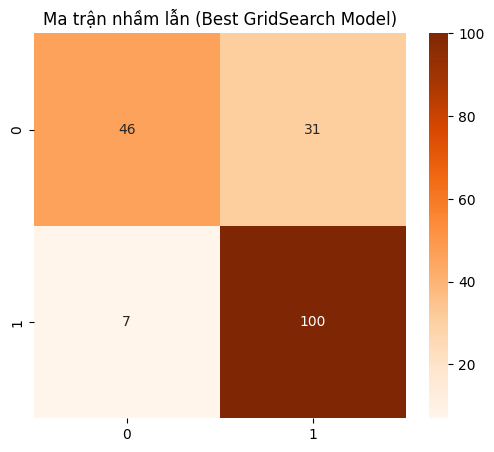

In [45]:
from sklearn.model_selection import GridSearchCV

# --- BƯỚC 5 (NÂNG CẤP): TÌM MODEL TỐT NHẤT BẰNG GRID SEARCH ---

# 1. Định nghĩa "lưới" các tham số muốn thử
# Máy sẽ thử tổ hợp: C=0.1 + liblinear, C=0.1 + lbfgs, C=1 + liblinear... v.v.
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Thử độ mạnh yếu của Regularization
    'solver': ['liblinear', 'lbfgs'], # Thử các bộ giải toán học khác nhau
    'class_weight': [None, 'balanced', {0:1, 1:3}] # Kết hợp luôn cả trọng số lớp
}

print("Đang chạy Grid Search để tìm tham số tối ưu...")

# 2. Khởi tạo GridSearch
# cv=5 nghĩa là Cross-Validation 5 lần (chia dữ liệu làm 5 phần để kiểm tra chéo) - Rất uy tín
grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                           param_grid, 
                           cv=5, 
                           scoring='recall') # Ưu tiên tìm model có Recall cao nhất (tránh bỏ sót bệnh)

# 3. Huấn luyện (Máy sẽ chạy rất nhiều model ngầm bên dưới)
grid_search.fit(X_train_scaled, y_train)

# 4. Lấy ra model tốt nhất
best_model = grid_search.best_estimator_

print("\n--- KẾT QUẢ TỐI ƯU ---")
print(f"Tham số tốt nhất tìm được: {grid_search.best_params_}")
print(f"Điểm Recall tốt nhất trên tập Train: {grid_search.best_score_:.2f}")

# --- BƯỚC 6: DỰ ĐOÁN BẰNG MODEL TỐT NHẤT ---
# Lưu ý: Lúc này dùng best_model để dự đoán
y_pred_optimized = best_model.predict(X_test_scaled)

print("\nBáo cáo trên tập Test (Model đã tối ưu):")
print(classification_report(y_test, y_pred_optimized))

# Vẽ Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_optimized), annot=True, fmt='d', cmap='Oranges')
plt.title('Ma trận nhầm lẫn (Best GridSearch Model)')
plt.show()

Chạy GridSearchCV với Pipeline + StratifiedKFold...
✓ Mỗi fold sẽ tự scaling riêng → Tránh Data Leakage hoàn toàn

✓ Hoàn thành Grid Search!

Tham số tốt nhất: {'model__C': 0.01, 'model__class_weight': {0: 1, 1: 2}}
Recall score (CV): 0.9327

=== KẾT QUẢ PIPELINE + STRATIFIED K-FOLD ===
              precision    recall  f1-score   support

           0       0.85      0.75      0.80        77
           1       0.84      0.91      0.87       107

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184

AUC-ROC Score: 0.9074


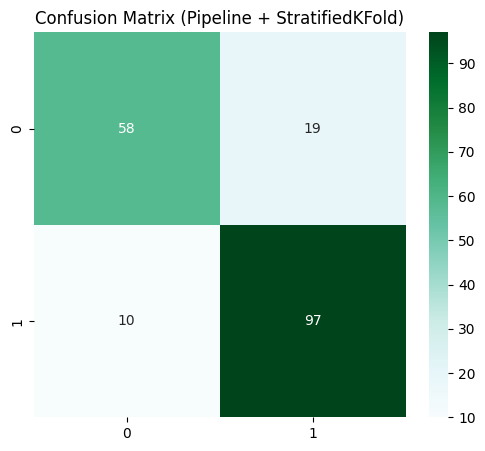

In [46]:
# --- BƯỚC 10 (ADVANCED): TỐI ƯU HÓA VỚI PIPELINE + STRATIFIEDKFOLD ---
# VẤN ĐỀ CŨ: GridSearch không tái scaling dữ liệu ở mỗi fold → Data Leakage lẩn tẩn
# GIẢI PHÁP: Dùng Pipeline để đảm bảo scaling được fit riêng trên từng training fold

from sklearn.pipeline import Pipeline

# 1. Tạo Pipeline: StandardScaler → LogisticRegression
# Lợi ích: Scaling sẽ được fit riêm trong mỗi fold của cross-validation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=42, max_iter=1000))
])

# 2. Định nghĩa tham số cho GridSearch (không cần C nếu chỉ dùng default)
param_grid_pipeline = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__class_weight': [None, 'balanced', {0:1, 1:2}]
}

# 3. Dùng StratifiedKFold thay vì KFold mặc định (đảm bảo class balance trong mỗi fold)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Chạy GridSearchCV với Pipeline + StratifiedKFold...")
print("✓ Mỗi fold sẽ tự scaling riêng → Tránh Data Leakage hoàn toàn\n")

grid_search_pipeline = GridSearchCV(
    pipeline, 
    param_grid_pipeline, 
    cv=stratified_kfold,
    scoring='recall',
    n_jobs=-1  # Dùng tất cả CPU cores để chạy nhanh hơn
)

# 4. Huấn luyện trên full training data (X_train_scaled, y_train từ trước)
# Lưu ý: X_train_scaled là dữ liệu đã scaling sẵn, nhưng trong Pipeline sẽ scaling lại từ X_train (chưa scale)
# Do vậy cần input X_train (raw data), không phải X_train_scaled
grid_search_pipeline.fit(X_train, y_train)

print("✓ Hoàn thành Grid Search!")
print(f"\nTham số tốt nhất: {grid_search_pipeline.best_params_}")
print(f"Recall score (CV): {grid_search_pipeline.best_score_:.4f}\n")

best_pipeline = grid_search_pipeline.best_estimator_

# 5. Dự đoán trên test set (Pipeline tự động scaling)
y_pred_pipeline = best_pipeline.predict(X_test)
y_prob_pipeline = best_pipeline.predict_proba(X_test)[:, 1]

print("=== KẾT QUẢ PIPELINE + STRATIFIED K-FOLD ===")
print(classification_report(y_test, y_pred_pipeline))
print(f"AUC-ROC Score: {roc_auc_score(y_test, y_prob_pipeline):.4f}")

plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_pipeline), annot=True, fmt='d', cmap= 'BuGn')
plt.title('Confusion Matrix (Pipeline + StratifiedKFold)')
plt.show()


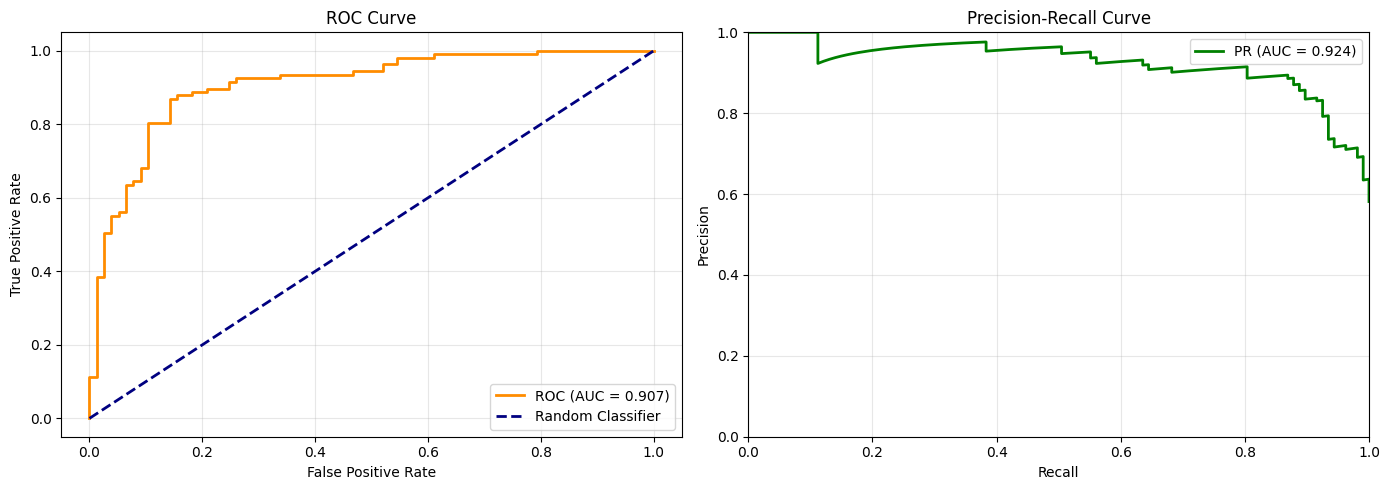

AUC-ROC: 0.9074
AUC-PR: 0.9238


In [47]:
# --- BƯỚC 11: VẼ ROC-CURVE & PRECISION-RECALL CURVE ---
# Để hiểu rõ hơn mô hình, cần xem thêm các metrics khác ngoài Accuracy

from sklearn.metrics import precision_recall_curve, auc as pr_auc

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ========== ROC CURVE ==========
# Cao càng tốt (nằm gần góc trên trái). Diện tích dưới đường = AUC-ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_pipeline)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc="lower right")
axes[0].grid(alpha=0.3)

# ========== PRECISION-RECALL CURVE ==========
# Dùng khi dữ liệu imbalanced (một class ít hơn rất nhiều)
# Cao càng tốt (nằm gần góc trên phải)
precision, recall, _ = precision_recall_curve(y_test, y_prob_pipeline)
pr_auc_score = pr_auc(recall, precision)

axes[1].plot(recall, precision, color='green', lw=2, label=f'PR (AUC = {pr_auc_score:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc="upper right")
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")
print(f"AUC-PR: {pr_auc_score:.4f}")


=== BẮT ĐẦU HUẤN LUYỆN (GRADIENT DESCENT) ===
Vòng 0: Loss = 0.6931
Vòng 100: Loss = 0.3677
Vòng 200: Loss = 0.3626
Vòng 300: Loss = 0.3619
Vòng 400: Loss = 0.3617
Vòng 500: Loss = 0.3617
Vòng 600: Loss = 0.3617
Vòng 700: Loss = 0.3617
Vòng 800: Loss = 0.3617
Vòng 900: Loss = 0.3617
Vòng 1000: Loss = 0.3617
Vòng 1100: Loss = 0.3617
Vòng 1200: Loss = 0.3617
Vòng 1300: Loss = 0.3617
Vòng 1400: Loss = 0.3617
Vòng 1500: Loss = 0.3617
Vòng 1600: Loss = 0.3617
Vòng 1700: Loss = 0.3617
Vòng 1800: Loss = 0.3617
Vòng 1900: Loss = 0.3617

=== KẾT QUẢ ĐÁNH GIÁ ===
Độ chính xác (Accuracy): 85.33%

Báo cáo chi tiết:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        77
           1       0.91      0.83      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



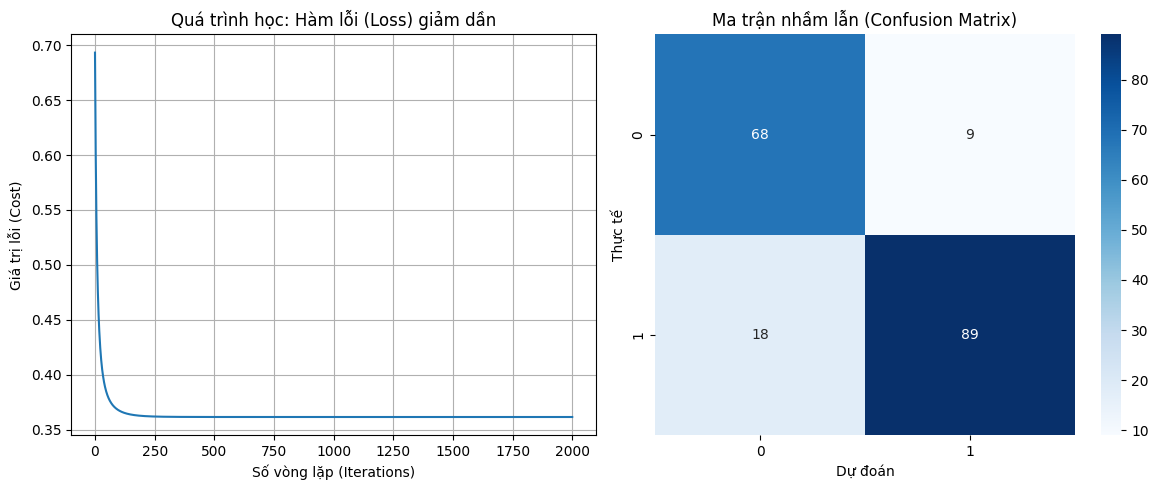

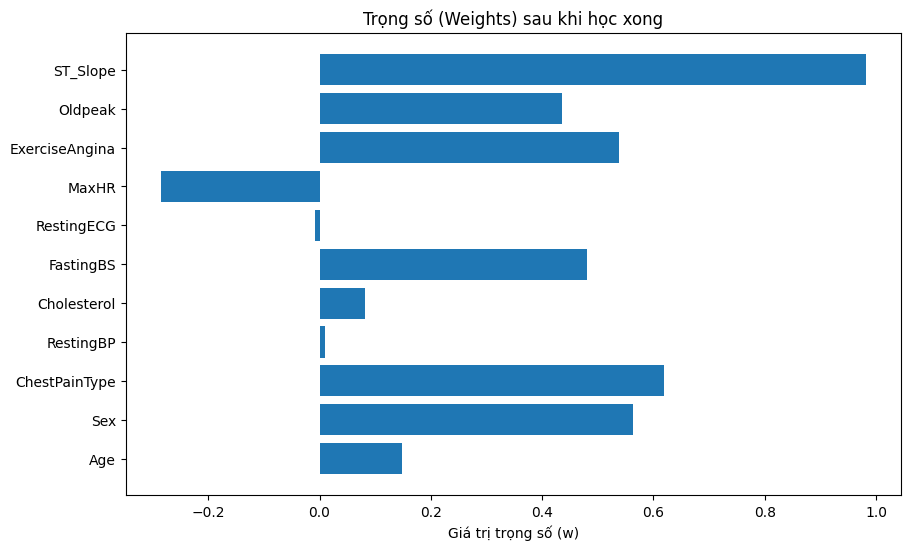

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ==============================================================================
# PHẦN 1: CÀI ĐẶT THUẬT TOÁN TỪ CON SỐ 0 (CORE ALGORITHM)
# (Đây là phần quan trọng nhất để báo cáo)
# ==============================================================================

class LogisticRegressionTuCode:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate # Tốc độ học (alpha)
        self.n_iterations = n_iterations   # Số lần lặp (epochs)
        self.weights = None                # Trọng số (w)
        self.bias = None                   # Hệ số tự do (b)
        self.cost_history = []             # Lưu lại lịch sử lỗi để vẽ biểu đồ

    # Hàm Sigmoid (Slide trang 7): Biến đổi z thành xác suất (0-1)
    # Công thức: 1 / (1 + e^-z)
    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # Hàm mất mát Binary Cross Entropy (Slide trang 11-12)
    def _compute_loss(self, y, y_predicted):
        m = len(y)
        # Thêm 1e-9 để tránh lỗi log(0)
        loss = -(1/m) * np.sum(y * np.log(y_predicted + 1e-9) + (1-y) * np.log(1 - y_predicted + 1e-9))
        return loss

    # Hàm huấn luyện (Fit) - Sử dụng Gradient Descent (Slide trang 13-16)
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # 1. Khởi tạo tham số w, b bằng 0 (Slide 14)
        self.weights = np.zeros(n_features)
        self.bias = 0

        # 2. Vòng lặp tối ưu hóa (Gradient Descent)
        for i in range(self.n_iterations):
            # --- Forward Propagation (Tính dự đoán) ---
            linear_model = np.dot(X, self.weights) + self.bias  # z = w.x + b
            y_predicted = self._sigmoid(linear_model)           # y_hat = sigmoid(z)

            # --- Backward Propagation (Tính đạo hàm) - Slide 16 ---
            # dw = (1/m) * sum((y_hat - y) * x)
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            # db = (1/m) * sum(y_hat - y)
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # --- Update Parameters (Cập nhật w, b) - Slide 15 ---
            # w = w - alpha * dw
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Lưu lại giá trị loss để theo dõi
            loss = self._compute_loss(y, y_predicted)
            self.cost_history.append(loss)
            
            # In ra tiến độ học mỗi 100 vòng
            if i % 10 == 0:
                print(f"Vòng {i}: Loss = {loss:.4f}")

    # Hàm dự đoán xác suất
    def predict_proba(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return self._sigmoid(linear_model)

    # Hàm dự đoán nhãn (0 hoặc 1)
    def predict(self, X, threshold=0.5):
        y_predicted_cls = [1 if i > threshold else 0 for i in self.predict_proba(X)]
        return np.array(y_predicted_cls)

# ==============================================================================
# PHẦN 2: XỬ LÝ DỮ LIỆU (DATA PREPROCESSING)
# ==============================================================================

# 1. Đọc dữ liệu
data = pd.read_csv('heart.csv')

# 2. Xử lý dữ liệu thô (Mapping chữ sang số)
mapping_config = {
    'ChestPainType': {'TA': 0, 'ATA': 1, 'NAP': 2, 'ASY': 3},
    'RestingECG':    {'Normal': 0, 'ST': 1, 'LVH': 2},
    'ExerciseAngina':{'Y': 1, 'N': 0},
    'ST_Slope':      {'Up': 0, 'Flat': 1, 'Down': 2},
    'Sex':           {'M': 1, 'F': 0}
}
df_final = data.copy()
for col, mapping in mapping_config.items():
    df_final[col] = df_final[col].map(mapping)

# 3. Xử lý Missing Value (Cholesterol)
df_final['Cholesterol'] = df_final['Cholesterol'].replace(0, np.nan)
# Lưu ý: Để đúng chuẩn toán học, ta tính median train xong mới fill, 
# nhưng ở đây làm đơn giản theo code cũ của bạn cũng chấp nhận được.
df_final['Cholesterol'] = df_final['Cholesterol'].fillna(df_final['Cholesterol'].median())

# 4. Chia dữ liệu Train/Test
X = df_final.drop('HeartDisease', axis=1).values # Chuyển về numpy array để tính toán
y = df_final['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Chuẩn hóa dữ liệu (Standard Scaling) - Tự code luôn cho đồng bộ
# Công thức: x_new = (x - mean) / std
def standard_scaler_scratch(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = standard_scaler_scratch(X_train, X_test)

# ==============================================================================
# PHẦN 3: HUẤN LUYỆN VÀ ĐÁNH GIÁ
# ==============================================================================

print("=== BẮT ĐẦU HUẤN LUYỆN (GRADIENT DESCENT) ===")
# Khởi tạo model tự viết
# learning_rate=0.01, chạy 2000 vòng lặp
model = LogisticRegressionTuCode(learning_rate=0.1, n_iterations=2000)

# Huấn luyện
model.fit(X_train_scaled, y_train)

# Dự đoán
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)

print("\n=== KẾT QUẢ ĐÁNH GIÁ ===")
print(f"Độ chính xác (Accuracy): {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nBáo cáo chi tiết:")
print(classification_report(y_test, y_pred))

# ==============================================================================
# PHẦN 4: TRỰC QUAN HÓA (CHỨNG MINH QUÁ TRÌNH HỌC)
# ==============================================================================

# Biểu đồ 1: Hàm mất mát (Loss Function) giảm dần theo thời gian
# Đây là bằng chứng thép cho việc Gradient Descent đang hoạt động
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model.cost_history)
plt.title('Quá trình học: Hàm lỗi (Loss) giảm dần')
plt.xlabel('Số vòng lặp (Iterations)')
plt.ylabel('Giá trị lỗi (Cost)')
plt.grid(True)

# Biểu đồ 2: Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')

plt.tight_layout()
plt.show()

# Biểu đồ 3: Xem trọng số (Weights) nào quan trọng nhất
feature_names = df_final.drop('HeartDisease', axis=1).columns
plt.figure(figsize=(10, 6))
plt.barh(feature_names, model.weights)
plt.title('Trọng số (Weights) sau khi học xong')
plt.xlabel('Giá trị trọng số (w)')
plt.show()